## Airplane Support Service

We are going to build a light weight version of a typical multi-agent support flow for an airline company and walk through how distillation can help a multi-agent set up.

### Classifier Agent

Fine-tuning when classifying user questions.

In [2]:
classifier_prompt = """
Classify customer support requests into one of the following categories related to airline services: "Flight Booking," "Flight Cancellation," "Flight Edit," "Flight Status," or "Escalate to a Human Agent." Each main category includes subcategories to refine the classification.

# Categories  
1. **Flight Booking**: Requests to book a new flight.
2. **Flight Cancellation**:  
    - a. **Cancel flight**: Requests to cancel an existing booking.
    - b. **Refund ticket**: Requests concerning a refund for a canceled booking.
3. **Flight Edit**:
    - a. **Change flight**: Requests to change flight details such as departure time, destination, etc.
    - b. **Change seat**: Requests to change seat assignments.
4. **Flight Status**:
    - a. **Check in / Boarding**: Requests related to flight check-in or boarding details.
    - b. **Baggage status**: Requests to inquire about baggage status.
5. **Escalate to a Human Agent**: Requests that require human assistance, typically when they are beyond the scope of categorized topics or involve specific, unique situations.

# Steps
1. Analyze the customer's request thoroughly by examining specific words or phrases used.
2. Think about the context in which particular words or questions appear.
3. Map the request to the appropriate category or subcategory based on its primary focus.
4. If the request cannot be clearly classified, or it involves urgency or a unique situation, classify it as "Escalate to a Human Agent".

# Output Format
- Provide the final output in JSON format.
- Include one field: "category" which contains one of "booking," "cancellation," "edit," "status," or "escalate".

# Example
**Input**: "I would like to cancel my upcoming trip to New York and get a refund."

**Output**:
{
  "category": "cancellation"
}

**Input**: "Can I please change my seat for my flight to Paris?"

**Output**:
{
  "category": "edit"
}

**Input**: "I'm unable to check-in online for my flight to Dallas."

**Output**:
{
  "category": "status"
}

**Input**: "I need help. I am not sure how to proceed with my booked tickets."

**Output**:
{
  "category": "escalate"
}

# Notes
- If a request provides minimal information and doesn't directly fit into a clear category, exercise caution and prioritize customer satisfaction by opting for escalation.
- Do not assume information beyond what the customer explicitly says; always stick to the provided phrases.
"""



In [3]:
prompts = [
    "I need to book a flight to London next month.",  # booking
    "Can I cancel my reservation without fees?",  # cancellation
    "I want to change my seat on my upcoming flight.",  # edit
    "What's the status of my flight to Tokyo?",  # status
    "I'm having trouble with my booking and need help.",  # escalate
    "Could I edit the date of my reservation?",  # edit
    "I need to check the status of my flight to Berlin.",  # status
    "I would like to cancel my order and get a refund.",  # cancellation
    "Is it possible to edit my booking to upgrade to business class?",  # edit
    "My flight to Sydney is delayed; what's my option?",  # status
    "I want to cancel my flight and rebook for another date.",  # cancellation
    "Can you help me change my seat assignment?",  # edit
    "What's the status of my baggage?",  # status
    "I'm not sure how to proceed with my flight booking.",  # escalate
    "I need assistance with canceling my trip to Rome.",  # cancellation
    "How can I edit my flight itinerary?",  # edit
    "I have a problem with my current booking and need escalation.",  # escalate
    "What's the status update on my flight to Dubai?",  # status
    "I'd like to cancel my flight reservation.",  # cancellation
    "Can you help me check the status of my booking?",  # status
    "Hello, I'm having issues with my reservation.",  # escalate
    "Hi, I need to speak with someone about my booking.",  # escalate
    "Good day, I would like to cancel my flight and get a refund.",  # cancellation
    "I just landed and my flight is missing.",  # escalate
    "The airport staff was unhelpful during my delay.",  # escalate
    "Where can I find my ticket information?",  # status
    "I have a question about your loyalty program points.",  # escalate
    "My bag didn't arrive; what should I do?",  # status
    "I need to update my personal information on my booking.",  # edit
    "The website isn't loading when I try to book a flight.",  # escalate
    "I'd like to inquire about the baggage allowance for my ticket.",  # status
    "My travel plans have changed unexpectedly.",  # escalate
    "I'm considering booking a flight; what are my options?",  # booking
    "I want to book a flight to New York for next week.",  # booking
    "Can I book a round-trip flight to Paris?",  # booking
    "I'd like to book a last-minute flight.",  # booking
    "How do I book a multi-city trip?",  # booking
    "I need to book a business class ticket.",  # booking
    "Is there availability for a flight to Toronto tomorrow?",  # booking
    "I'd like to make a reservation for a flight to Chicago.",  # booking
    "Can you help me book a direct flight to Los Angeles?",  # booking
    "I want to secure a seat on the next available flight.",  # booking
    "Please assist me in booking a flight with flexible dates.",  # booking
    "I need to cancel my reservation due to a personal emergency.",  # cancellation
    "How do I cancel my flight and receive a refund?",  # cancellation
    "Can you help cancel my booking for the flight to Miami?",  # cancellation
    "I want to cancel my ticket without any charges.",  # cancellation
    "Please cancel my flight reservation and confirm.",  # cancellation
    "I'd like to terminate my booking for the upcoming flight.",  # cancellation
    "Can I cancel my flight booking and rebook later?",  # cancellation
    "I need to cancel my flight due to schedule changes.",  # cancellation
    "How can I process a cancellation for my flight to Seattle?",  # cancellation
    "Please help me cancel my airline reservation.",  # cancellation
    "What is the current status of my flight?",  # status
    "Can you provide a status update for my trip to Boston?",  # status
    "I'd like to check the status of my booking for tomorrow.",  # status
    "Is my flight to Denver on time?",  # status
    "What's the latest status on my flight itinerary?",  # status
    "Can you update me on the status of my flight to Austin?",  # status
    "I need to know the status of my booking.",  # status
    "What's the status of my ticket to Orlando?",  # status
    "Is my flight to Las Vegas delayed?",  # status
    "Can you check the status of my upcoming flight?",  # status
    "What's the flight status for my booking today?",  # status
    "I'd like to know the current status of my flight to Nashville.",  # status
    "Is there any update on my flight to Atlanta?",  # status
    "I need to change the date of my flight reservation.",  # edit
    "Can you help me modify my booking for a different destination?",  # edit
    "I'd like to update my seat preference on my flight.",  # edit
    "Is it possible to edit my flight number on the reservation?",  # edit
    "Please assist me in editing my flight times.",  # edit
    "I want to change my passenger details on my booking.",  # edit
    "How can I amend my flight itinerary for next week?",  # edit
    "Can I edit my reservation to include an additional baggage?",  # edit
    "I need to adjust my departure time on my flight reservation.",  # edit
    "Please help me edit my flight booking to add a return flight.",  # edit
    "I'd like to make changes to my existing flight reservation.",  # edit
    "How do I update my contact information on my booking?",  # edit
    "Can I edit my booking to switch from economy to premium class?",  # edit
    "I'm not satisfied with the support I'm receiving.",  # escalate
    "My issue hasn't been resolved; I need to escalate.",  # escalate
    "Please escalate my complaint to a supervisor.",  # escalate
    "I need to speak with higher management about my booking issues.",  # escalate
    "My flight was canceled and I need to escalate the matter.",  # escalate
    "I've been waiting too long for assistance; escalate my case.",  # escalate
    "The previous agent couldn't help me; please escalate.",  # escalate
    "I require immediate escalation due to my urgent travel needs.",  # escalate
    "My flight experience was poor, and I want to escalate the feedback.",  # escalate
    "Please escalate my request for a refund.",  # escalate
    "I need to escalate the issue with my missing baggage.",  # escalate
    "Can you escalate my complaint about the flight delay?",  # escalate
    "I want to escalate my ticketing problem to a manager.",  # escalate
    "The system isn't helping; I need to escalate my booking issue.",  # escalate
    "Please escalate my dissatisfaction with your services.",  # escalate
    "I need to escalate my concern about the overbooked flight.",  # escalate
]

test_prompts = [
    "I'd like to book a flight to Amsterdam for next weekend.",  # booking
    "Can I cancel my flight without any penalties?",  # cancellation
    "I need to modify my seat selection for my flight.",  # edit
    "What is the current status of my flight to Madrid?",  # status
    "I'm experiencing issues with my booking and need assistance.",  # escalate
    "Is it possible to change the date of my flight reservation?",  # edit
    "Please check the status of my flight to Vienna.",  # status
    "I want to cancel my ticket and receive a full refund.",  # cancellation
    "Can I upgrade my seat to first class on my existing booking?",  # edit
    "My flight to Frankfurt has been delayed; what are my options?",  # status
    "I need to cancel my reservation and book for a different date.",  # cancellation
    "Could you assist me in changing my seat assignment?",  # edit
    "What is the status of my checked luggage?",  # status
    "I'm unsure how to proceed with changing my flight booking.",  # escalate
    "I require help to cancel my journey to Barcelona.",  # cancellation
    "How can I update my flight itinerary for next month?",  # edit
    "There's an issue with my booking that needs to be escalated.",  # escalate
    "Can you provide a status update for my flight to Lisbon?",  # status
    "I'd like to terminate my flight reservation completely.",  # cancellation
    "Could you check the status of my upcoming flight booking?",  # status
    "Hi, I'm facing problems with my flight reservation.",  # escalate
    "Hello, I need to talk to someone regarding my booking issues.",  # escalate
    "Good afternoon, I wish to cancel my flight and get a refund.",  # cancellation
    "I missed my flight upon landing and need assistance.",  # escalate
    "The airline staff was not helpful during my flight delay.",  # escalate
    "Where can I access my flight ticket details?",  # status
    "I have inquiries about accumulating loyalty points.",  # escalate
    "My checked bag hasn't arrived; what steps should I take?",  # status
    "I need to update my contact details on my flight booking.",  # edit
    "The booking website is unresponsive when I try to make a reservation.",  # escalate
    "I'd like information on the baggage limits for my ticket.",  # status
    "Unexpected changes in my schedule require modifying my travel plans.",  # escalate
    "I'm planning to book a flight soon; what are the available options?",  # booking
    "I want to reserve a flight to San Francisco for the coming week.",  # booking
    "Is it possible to book a round-trip flight to Berlin?",  # booking
    "I'd like to secure a last-minute flight reservation.",  # booking
    "What is the process to book a multi-city flight itinerary?",  # booking
    "I need assistance in booking a premium class ticket.",  # booking
    "Are there any available flights to Houston tomorrow?",  # booking
    "I'd like to reserve a seat for my flight to Seattle.",  # booking
    "Can you help me book a non-stop flight to Denver?",  # booking
    "I want to ensure a seat on the earliest possible flight.",  # booking
    "Please help me book a flight with adjustable dates.",  # booking
    "I need to cancel my reservation because of an unforeseen emergency.",  # cancellation
    "How can I cancel my flight and get reimbursed?",  # cancellation
    "Can you assist in canceling my booking for the flight to Orlando?",  # cancellation
    "I wish to cancel my ticket without incurring any fees.",  # cancellation
    "Please terminate my flight reservation and send confirmation.",  # cancellation
    "I'd like to end my booking for the scheduled flight.",  # cancellation
    "Is it possible to cancel my flight booking and rebook at a later time?",  # cancellation
    "I need to cancel my flight due to changes in my schedule.",  # cancellation
    "How do I cancel my flight to Portland and what is the procedure?",  # cancellation
    "Please assist me in canceling my airline reservation.",  # cancellation
    "What is the latest status of my flight?",  # status
    "Can you provide an update on my trip to Philadelphia?",  # status
    "I'd like to verify the status of my booking for the next day.",  # status
    "Is my flight to Minneapolis scheduled on time?",  # status
    "What's the most recent status of my flight itinerary?",  # status
    "Can you inform me about the status of my flight to Houston?",  # status
    "I need to check the status of my booking details.",  # status
    "What's the status of my airline ticket to Orlando?",  # status
    "Is my flight to Las Vegas running behind schedule?",  # status
    "Can you verify the status of my upcoming flight?",  # status
    "What's the current flight status for my reservation today?",  # status
    "I'd like to know the current status of my flight to Nashville.",  # status
    "Is there a status update for my flight to Atlanta?",  # status
    "I need to alter the date of my flight reservation.",  # edit
    "Can you assist me in modifying my booking to a different destination?",  # edit
    "I'd like to change my seat preference for my flight.",  # edit
    "Is it feasible to edit my flight number in the reservation?",  # edit
    "Please help me adjust my flight times.",  # edit
    "I want to update the passenger details on my booking.",  # edit
    "How can I revise my flight itinerary for the upcoming week?",  # edit
    "Can I modify my reservation to add extra baggage?",  # edit
    "I need to change my departure time on my flight reservation.",  # edit
    "Please assist me in editing my flight booking to include a return trip.",  # edit
    "I'd like to make modifications to my existing flight reservation.",  # edit
    "How do I update my contact information on my flight booking?",  # edit
    "Can I change my booking from economy to business class?",  # edit
    "I'm unhappy with the support provided and need to escalate.",  # escalate
    "My problem remains unresolved; I need to escalate this issue.",  # escalate
    "Please forward my complaint to a supervisor immediately.",  # escalate
    "I need to discuss my booking issues with higher management.",  # escalate
    "My flight was canceled, and I need to escalate the situation.",  # escalate
    "I've waited too long for help; please escalate my case.",  # escalate
    "The agent before couldn't resolve my issue; please escalate.",  # escalate
    "I need urgent escalation due to critical travel requirements.",  # escalate
    "My flight experience was disappointing, and I want to escalate my feedback.",  # escalate
    "Please escalate my refund request as soon as possible.",  # escalate
    "I need to escalate the problem with my lost baggage.",  # escalate
    "Can you escalate my complaint regarding the flight delay?",  # escalate
    "I want to escalate my ticketing issue to a manager's attention.",  # escalate
    "The booking system isn't assisting me; I need to escalate my issue.",  # escalate
    "Please escalate my dissatisfaction with the provided services.",  # escalate
    "I need to escalate my concerns about the overbooked flight.",  # escalate
]

Run classifier on 4o

In [4]:
from openai import OpenAI
import concurrent.futures

client = OpenAI()

def process_prompt(prompt):
    messages = [
        {"role": "system", "content": classifier_prompt},
        {"role": "user", "content": prompt}
    ]
    model = "gpt-4o"
    metadata = {"model": model, "stage": "classifier", "project": "airplane", "run": "2"}
    res = client.chat.completions.create(
        model=model,
        messages=messages,
        store=True,
        metadata=metadata,
        response_format={"type": "json_object"}
    )
    print(res.choices[0].message.content)

with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(process_prompt, prompts)

{
  "category": "edit"
}
{
  "category": "escalate"
}
{
  "category": "edit"
}
{
  "category": "booking"
}
{
  "category": "edit"
}
{
  "category": "cancellation"
}
{
  "category": "escalate"
}
{
  "category": "cancellation"
}
{
  "category": "edit"
}
{
  "category": "edit"
}
{
  "category": "status"
}
{
  "category": "edit"
}
{
  "category": "status"
}
{
  "category": "status"
}
{
  "category": "status"
}
{
  "category": "cancellation"
}
{
  "category": "escalate"
}
{
  "category": "escalate"
}
{
  "category": "escalate"
}
{
  "category": "escalate"
}
{
  "category": "escalate"
}
{
  "category": "cancellation"
}
{
  "category": "escalate"
}
{
  "category": "escalate"
}
{
  "category": "status"
}
{
  "category": "edit"
}
{
  "category": "status"
}
{
  "category": "escalate"
}
{
  "category": "escalate"
}
{
  "category": "status"
}
{
  "category": "escalate"
}
{
  "category": "booking"
}
{
  "category": "escalate"
}
{
  "category": "booking"
}
{
  "category": "booking"
}
{
  "category":

Check test set on distilled 4o-mini

In [ ]:
def process_prompt(prompt):
    messages = [
        {"role": "system", "content": classifier_prompt},
        {"role": "user", "content": prompt}
    ]
    model = "gpt-4o"
    metadata = {"model": model, "stage": "classifier", "project": "airplane", "run": "3"}
    res = client.chat.completions.create(
        model=model,
        messages=messages,
        store=True,
        metadata=metadata,
        response_format={"type": "json_object"}
    )
    print(res.choices[0].message.content)

with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(process_prompt, test_prompts)

### Status Agent

Fine-tuning when tool calls are present

In [7]:
status_prompt = """
You are a support assistant handling flight status requests. You have access to two tools: "check_in" and "baggage".

# Tools:
1. **check_in**: Provides information related to flight check-in or boarding details.
   - **Parameters Required**:
     - `passenger_id`
     - `departure_date`

2. **baggage**: Provides information about baggage status.
   - **Parameters Required**:
     - `passenger_id`
     - `flight_number`

# Instructions:
1. **Analyze the Request**:
   - Determine if the customer's request pertains to **check-in/boarding** or **baggage**.
   
2. **Determine Required Information**:
   - **For Check-In/Boarding**:
     - Ensure both `passenger_id` and `departure_date` are provided.
   - **For Baggage**:
     - Ensure both `passenger_id` and `flight_number` are provided.

3. **Action Based on Information Availability**:
   - **If All Required Information is Present**:
     - **Check-In/Boarding Requests**:
       - Call the **check_in** function with the provided `passenger_id` and `departure_date`.
     - **Baggage Requests**:
       - Call the **baggage** function with the provided `passenger_id` and `flight_number`.
   
   - **If Information is Missing**:
     - Identify which parameters are missing.
     - Prompt the user to provide the missing information.

4. **Handle Irrelevant Requests**:
   - If the request does not pertain to flight status, respond accordingly or escalate if necessary.
"""

tools = [
  {
    "type": "function",
    "function": {
        "name": "check_in",
        "description": "Requests related to flight check-in or boarding details.",
        "strict": True,
        "parameters": {
        "type": "object",
        "required": [
          "passenger_id",
          "departure_date",
        ],
        "properties": {
          "passenger_id": {
            "type": "string",
            "description": "Identification number of the passenger"
          },
          "departure_date": {
            "type": "string",
            "description": "The date of departure in YYYY-MM-DD format"
          }
        },
        "additionalProperties": False
      }
    }
  },
  {
    "type": "function",
    "function": {
      "name": "inquire_baggage_status",
      "description": "Requests to inquire about baggage status. Need all the information before checking this for a user.",
      "strict": True,
      "parameters": {
        "type": "object",
        "required": [
          "passenger_id",
          "flight_number"
        ],
        "properties": {
          "passenger_id": {
            "type": "string",
            "description": "Unique identifier for the user making the inquiry"
          },
          "flight_number": {
            "type": "string",
            "description": "Flight number associated with the baggage"
          }
        },
        "additionalProperties": False
      }
    }
  }
]



In [10]:
example_prompts = [
    "I need to check in for my flight tomorrow.",  # Function: check_in
    "Can you help me with my baggage status?",  # Function: baggage
    "What time does the boarding for flight AA123 start?",  # Function: check_in
    "My luggage hasn't arrived yet. What should I do?",  # Function: baggage
    "How do I update my departure date for check-in?",  # Function: check_in
    "Where can I find the baggage claim area?",  # Function: baggage
    "Is online check-in available for my flight?",  # Function: check_in
    "Can you track my checked baggage for flight BA456?",  # Function: baggage
    "What is the boarding gate for flight DL789?",  # Function: check_in
    "I want to add an extra bag to my reservation.",  # Function: baggage
    "How early should I arrive for check-in?",  # Function: check_in
    "Where is my baggage currently located?",  # Function: baggage
    "Can I check in using my mobile device?",  # Function: check_in
    "What is the limit for checked baggage weight?",  # Function: baggage
    "My flight was canceled. How do I get a refund?",  # Function: check_in
    "Is there a fee for overweight baggage?",  # Function: baggage
    "Can I change my seat during check-in?",  # Function: check_in
    "Where can I report lost baggage?",  # Function: baggage
    "What documents do I need for international check-in?",  # Function: check_in
    "How do I know if my baggage is delayed?",  # Function: baggage
    "Can I check in at the airport kiosk?",  # Function: check_in
    "What are the boarding pass requirements?",  # Function: check_in
    "How do I retrieve my baggage claim ticket?",  # Function: baggage
    "Is priority boarding available for my flight?",  # Function: check_in
    "What happens if I miss the check-in deadline?",  # Function: check_in
    "How can I expedite my baggage delivery?",  # Function: baggage
    "Can I get a boarding pass via email?",  # Function: check_in
    "Where is the nearest baggage carousel?",  # Function: baggage
    "How do I add a companion to my flight check-in?",  # Function: check_in
    "What should I do if my baggage is damaged?",  # Function: baggage
    "Can I print my boarding pass at home?",  # Function: check_in
    "What is the procedure for international baggage?",  # Function: baggage
    "How do I access my boarding information online?",  # Function: check_in
    "Is there a limit to the number of bags I can check?",  # Function: baggage
    "How do I update my passenger ID for baggage?",  # Function: baggage
    "What are the check-in counter hours?",  # Function: check_in
    "Can I request special assistance during check-in?",  # Function: check_in
    "How do I verify my baggage has been loaded?",  # Function: baggage
    "What time does the baggage claim open?",  # Function: baggage
    "Can I upgrade my baggage allowance during check-in?",  # Function: baggage
    "What information do I need to inquire about my baggage?",  # Function: baggage
    "How long before departure should I complete check-in?",  # Function: check_in
    "Where can I find information about baggage restrictions?",  # Function: baggage
    "Can I postpone my check-in for a later time?",  # Function: check_in
    "What should I do if my flight's boarding gate changes?",  # Function: check_in
    "How do I cancel my check-in?",  # Function: check_in
    "Can I get notifications about my baggage status?",  # Function: baggage
    "What are the procedures for checking in oversized luggage?",  # Function: baggage
    "How do I handle a missed connection during check-in?",  # Function: check_in
    "Where can I get assistance with my baggage issues?",  # Function: baggage
    "Can I split my baggage across multiple flights?",  # Function: baggage
    "What security measures are in place during check-in?",  # Function: check_in
    "I need to check in for my flight tomorrow using passenger ID ABC123 and departure date 2023-10-01.",  # Function: check_in
    "Please provide the baggage status for passenger ID XYZ789 and flight number BA456.",  # Function: baggage
    "Can I check in online with passenger ID LMN456 and departure date 2023-12-15?",  # Function: check_in
    "Track my baggage for passenger ID DEF321 and flight number AA123.",  # Function: baggage
]

status_test = [
    "Can I change my departure time for flight UA321?",  # Function: check_in
    "My baggage was lost. How can I file a report?",  # Function: baggage
    "Is there a vegetarian meal option available on my flight?",  # Function: check_in
    "Where is the nearest restroom in the terminal?",  # Function: baggage
    "How do I select my seat during check-in?",  # Function: check_in
    "What to do if my baggage is overweight?",  # Function: baggage
    "Can I get a delayed check-in due to late arrival?",  # Function: check_in
    "How can I track my checked-in baggage?",  # Function: baggage
    "What documents are required for check-in?",  # Function: check_in
    "Is there a fee for checking additional bags?",  # Function: baggage
    "Can I upgrade my seat after checking in?",  # Function: check_in
    "How do I change my flight destination?",  # Function: check_in
    "Where can I find the lost and found for baggage?",  # Function: baggage
    "Can I add a pet to my luggage?",  # Function: baggage
    "What are the check-in procedures for business class?",  # Function: check_in
    "How do I retrieve my ticket after canceling my flight?",  # Function: baggage
    "Is there a priority baggage service available?",  # Function: baggage
    "Can I modify my passenger ID after booking?",  # Function: baggage
    "What is the maximum size for carry-on luggage?",  # Function: baggage
    "How do I report a damaged suitcase?",  # Function: baggage
    "Can I check in multiple passengers at once?",  # Function: check_in
    "What happens to my baggage if my flight is diverted?",  # Function: baggage
    "Is there a self-service check-in option available?",  # Function: check_in
    "How do I locate my boarding pass in the app?",  # Function: check_in
    "Can I send my baggage directly to my destination?",  # Function: baggage
    "What are the baggage drop-off deadlines?",  # Function: baggage
    "How do I change my flight without losing my baggage?",  # Function: check_in
    "Are there any discounts for additional baggage?",  # Function: baggage
    "Can I request a window seat during check-in?",  # Function: check_in
    "What is the process for oversized baggage?",  # Function: baggage
    "How do I find out if my flight is on time?",  # Function: check_in
    "Can I reroute my baggage to a different airport?",  # Function: baggage
    "What assistance is available for travelers with disabilities during check-in?",  # Function: check_in
    "How do I ensure my baggage is correctly tagged?",  # Function: baggage
    "Can I check in my baggage online?",  # Function: check_in
    "What are the prohibited items in checked baggage?",  # Function: baggage
    "How do I change my travel date after checking in?",  # Function: check_in
    "Is there a baggage tracking system available?",  # Function: baggage
    "Can I store my baggage at the airport for a day?",  # Function: baggage
    "How do I update my flight details after booking?",  # Function: check_in
    "What should I do if my baggage is sent to the wrong destination?",  # Function: baggage
    "Can I receive an email confirmation for my check-in?",  # Function: check_in
    "What are the steps to check in for an international flight?",  # Function: check_in
    "Is there a limit to the number of carry-on bags?",  # Function: baggage
    "How do I link my frequent flyer account during check-in?",  # Function: check_in
    "What fees apply for excess baggage?",  # Function: baggage
    "Can I check in without printing my boarding pass?",  # Function: check_in
    "How do I handle overweight baggage charges?",  # Function: baggage
    "Where can I find the check-in counters for my airline?",  # Function: check_in
    "Can I modify my baggage allowance after booking?",  # Function: baggage
]


In [ ]:
def process_prompt(prompt):
    messages = [
        {"role": "system", "content": status_prompt},
        {"role": "user", "content": prompt}
    ]
    model = "gpt-4o" # swap out model
    metadata = {"model": model, "stage": "status", "project": "airplane", "run": "1"}
    res = client.chat.completions.create(
        model=model,
        messages=messages,
        store=True,
        metadata=metadata,
        tools=tools
    )
    print(res.choices[0].message.content)

with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(process_prompt, example_prompts)

### Guardrails
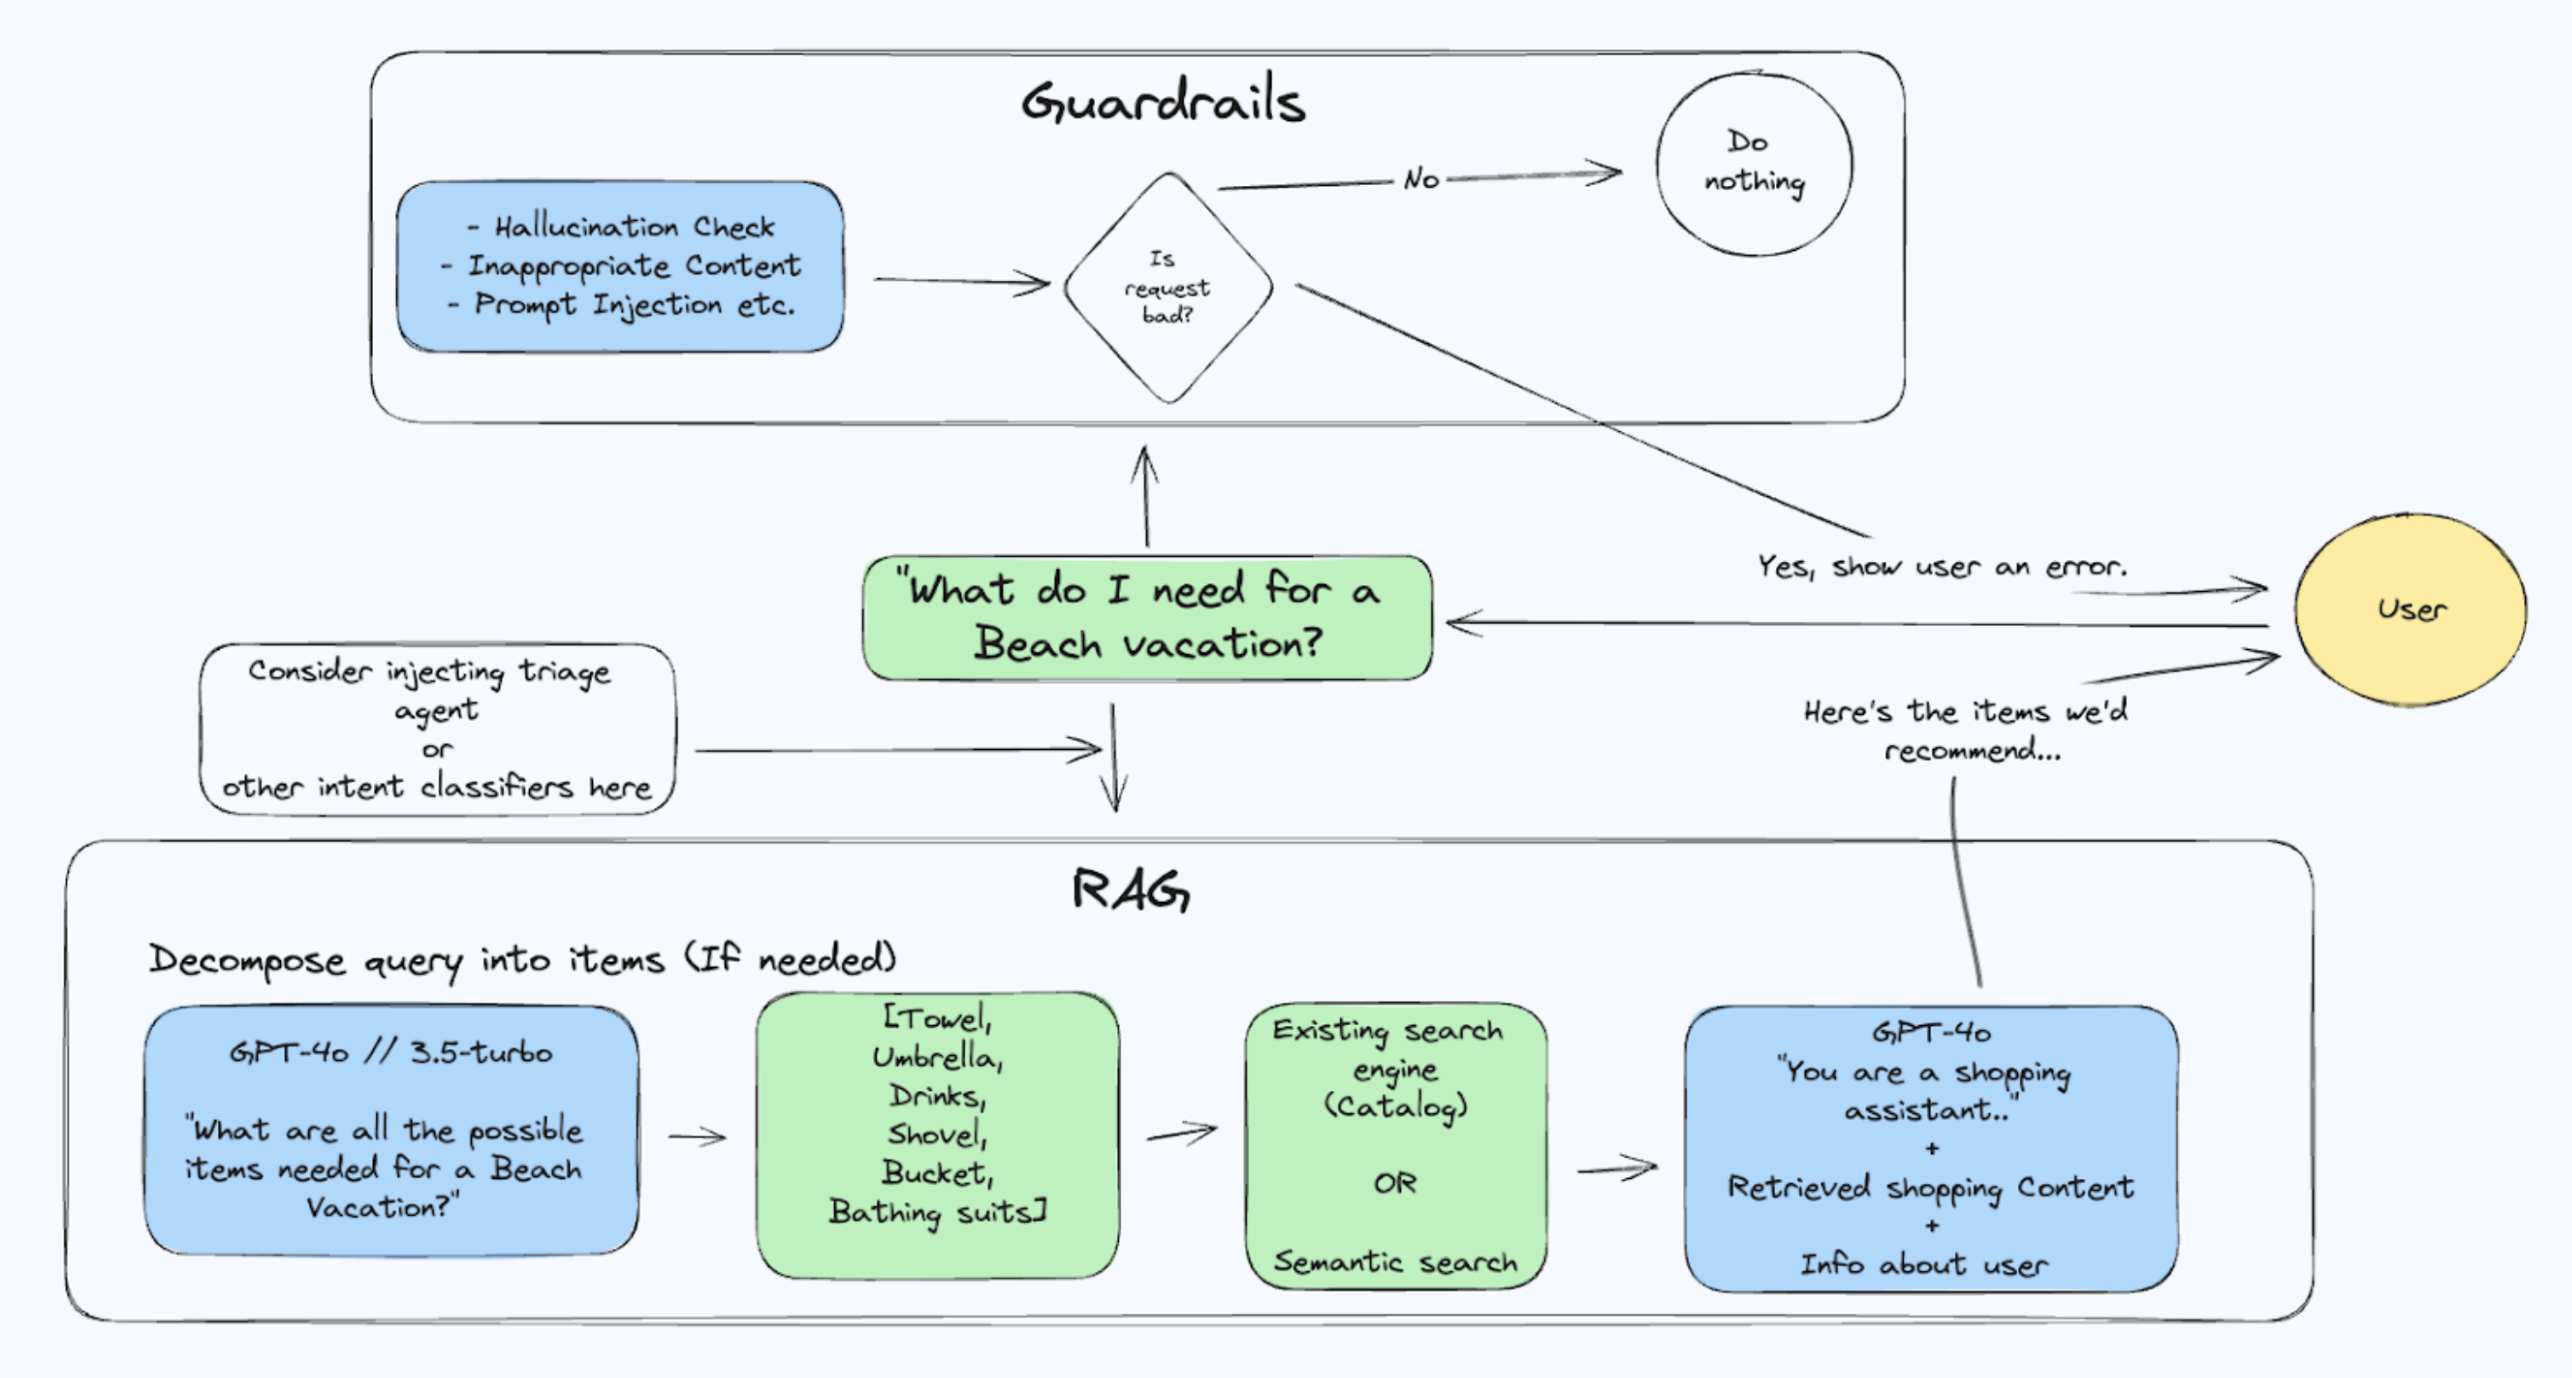

In [14]:
guardrail_prompt = """
You are a support assistant trained to handle inquiries only related to specific airline services. Before responding, check if the request is relevant to one of the following service categories:

Flight Booking - Requests for booking a new flight.
Flight Cancellation - Requests to cancel or refund a flight.
Flight Edit - Requests to change flight details (e.g., time, destination, or seat).
Flight Status - Requests about flight status, boarding, or baggage.
Escalate to a Human Agent - Requests that require further human assistance.
Steps to Evaluate Relevance:

Analyze Content - Check if the request mentions specific airline-related keywords like "book," "cancel," "refund," "change flight," "seat," "status," "check-in," "boarding," or "baggage."
Match to Category - Determine if the request fits into one of the five categories. If it doesn’t directly align, consider if it could still fall under "Escalate to a Human Agent."
Deflect Irrelevant Questions - If the question doesn't fit any of the categories or doesn't contain keywords or phrases related to airline services, provide a deflection response.

For any question in the above categories, respond as follows:

{
  "response": "Approve"
}

For any question outside of the above categories, respond as follows:

{
  "response": "I'm here to assist with airline-related services like booking, cancellations, flight changes, status updates, and other specific travel inquiries. Please rephrase or ask about one of these topics, and I’ll be happy to help."
}

"""

In [12]:
sample_prompts = [
    "I need to book a flight from New York to London next Monday.",  # Pass
    "Can I get a refund for my flight?",  # Pass
    "I'd like to change my seat on flight 123.",  # Pass
    "What's the status of flight 456?",  # Pass
    "How do I check in online?",  # Pass
    "I want to cancel my reservation.",  # Pass
    "Can you help me with my baggage?",  # Pass
    "What's the boarding gate for flight 789?",  # Pass
    "I need assistance with travel insurance.",  # Fail
    "What's the policy for changing flight times?",  # Pass
    "I'd like to upgrade my seat.",  # Pass
    "Can I get a discount on my next flight?",  # Fail
    "How do I manage my booking?",  # Pass
    "I want to know the baggage allowance.",  # Pass
    "What's the procedure to cancel my booking?",  # Pass
    "How do I track my flight status?",  # Pass
    "I need to speak to a human agent regarding my flight.",  # Pass
    "Can you help me find a flight?",  # Pass
    "How do I apply for a refund?",  # Pass
    "I'd like to reschedule my flight.",  # Pass
    "What's the flight cancellation policy?",  # Pass
    "Can you assist me with my itinerary?",  # Pass
    "I have a question about my boarding pass.",  # Pass
    "How do I change my destination?",  # Pass
    "What's the cost to change my flight?",  # Pass
    "I need help with seat selection.",  # Pass
    "Is there a fee for cancelling my flight?",  # Pass
    "Can you provide information on flight delays?",  # Pass
    "I'd like to modify my travel plans.",  # Pass
    "How do I check my flight's ETA?",  # Pass
    "I want to know about lounge access.",  # Fail
    "Can you help me with my travel itinerary?",  # Pass
    "What's the procedure for flight cancellation?",  # Pass
    "I need to report a lost luggage.",  # Pass
    "How do I upgrade my flight class?",  # Pass
    "Can I get a refund for a delayed flight?",  # Pass
    "I want to change my flight destination.",  # Pass
    "What's the process to edit my booking?",  # Pass
    "Can you assist with my travel documents?",  # Fail
    "How do I get a voucher for a cancelled flight?",  # Pass
    "I need directions to the departure gate.",  # Pass
    "What's the process to check flight status?",  # Pass
    "Can you help with my flight insurance?",  # Fail
    "I'd like to cancel my upgrade.",  # Pass
    "How do I adjust my flight times?",  # Pass
    "I want to inquire about baggage fees.",  # Pass
    "Can you connect me to a customer service representative?",  # Pass
    "I have a complaint about my flight experience.",  # Pass
    "What's the best way to rebook a flight?",  # Pass
    "How do I obtain a flight refund?"  # Pass
]

test_prompts = [
    "Can I change my flight from Chicago to Tokyo to next Friday?",  # Pass
    "What is the baggage fee for extra luggage on flight 321?",  # Pass
    "How do I upgrade to business class on my current booking?",  # Pass
    "I need assistance with my hotel reservation.",  # Fail
    "What are the check-in times for international flights?",  # Pass
    "Can you help me find a vegetarian meal on my flight?",  # Pass
    "How do I apply for a visa for my trip to Germany?",  # Fail
    "Is there a discount for students on flight tickets?",  # Pass
    "What is the procedure for lost passport recovery?",  # Fail
    "Can I select my seat in advance for flight 789?",  # Pass
    "How do I cancel my seat upgrade?",  # Pass
    "What are the in-flight entertainment options available?",  # Pass
    "I need to report a fraudulent charge on my credit card.",  # Fail
    "Can you provide information on pet travel policies?",  # Pass
    "How do I change my flight destination from Miami to Seattle?",  # Pass
    "What is the process for obtaining a travel visa?",  # Fail
    "Can I request a window seat for my upcoming flight?",  # Pass
    "How do I add an extra legroom seat to my booking?",  # Pass
    "What amenities are offered in first-class cabins?",  # Pass
    "I want to book a round-trip flight to Paris.",  # Pass
    "How do I update my contact information for my flight reservation?",  # Pass
    "What is the cancellation policy for non-refundable tickets?",  # Pass
    "Can you assist me with arranging airport transfers?",  # Fail
    "How do I change the name on my flight ticket?",  # Pass
    "What are the options for flight meal preferences?",  # Pass
    "I need help with my car rental booking.",  # Fail
    "Can I get a refund for a canceled flight due to weather?",  # Pass
    "How do I request a wheelchair for my flight?",  # Pass
    "What is the procedure for upgrading my frequent flyer status?",  # Pass
    "Can you provide details on flight delay compensation?",  # Pass
    "How do I book a multi-city flight itinerary?",  # Pass
    "What are the baggage weight limits for international flights?",  # Pass
    "I want to change my departure time for flight 654.",  # Pass
    "How do I add a companion to my flight booking?",  # Pass
    "What services are available for unaccompanied minors?",  # Pass
    "Can you help me book a last-minute flight?",  # Pass
    "How do I earn more miles with my current airline?",  # Pass
    "What are the policies for transporting musical instruments?",  # Pass
    "I need to update my payment method for my flight booking.",  # Pass
    "Can I request an early boarding for my flight?",  # Pass
    "How do I cancel my flight and what are the fees involved?",  # Pass
    "What is the process to change my seat after booking?",  # Pass
    "Can you assist me with travel insurance options for my trip?",  # Pass
    "How do I book a flight using my credit card miles?",  # Pass
    "What are the check-in procedures for connecting flights?",  # Pass
    "I need information on the airline's COVID-19 policies.",  # Pass
    "Can I change my flight without incurring a fee?",  # Pass
    "How do I report a damaged suitcase upon arrival?",  # Pass
    "What are the best practices for booking flights during peak season?",  # Pass
    "I want to know the lounge access eligibility criteria.",  # Pass
    "Can you help me find flights with flexible dates?",  # Pass
]



In [18]:
def process_prompt(prompt):
    messages = [
        {"role": "system", "content": guardrail_prompt},
        {"role": "user", "content": prompt}
    ]
    model = "gpt-4o" # swap out model
    metadata = {"model": model, "stage": "guardrail", "project": "airplane", "run": "2"}
    res = client.chat.completions.create(
        model=model,
        messages=messages,
        store=True,
        metadata=metadata
    )
    print(res.choices[0].message.content)

with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(process_prompt, sample_prompts)

{
  "response": "Approve"
}
{
  "response": "Approve"
}
{
  "response": "Approve"
}
{
  "response": "Approve"
}
{
  "response": "Approve"
}
{
  "response": "Approve"
}
{
  "response": "Approve"
}
{
  "response": "Approve"
}
{
  "response": "Approve"
}
{
  "response": "Approve"
}
{
  "response": "I'm here to assist with airline-related services like booking, cancellations, flight changes, status updates, and other specific travel inquiries. Please rephrase or ask about one of these topics, and I’ll be happy to help."
}
{
  "response": "I'm here to assist with airline-related services like booking, cancellations, flight changes, status updates, and other specific travel inquiries. Please rephrase or ask about one of these topics, and I’ll be happy to help."
}
{
  "response": "I'm here to assist with airline-related services like booking, cancellations, flight changes, status updates, and other specific travel inquiries. Please rephrase or ask about one of these topics, and I’ll be happy 